In [23]:
# ## install finrl library
# !pip install wrds
# !pip install swig
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [24]:
import warnings
warnings.filterwarnings("ignore")

In [25]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [26]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [27]:
# TODO, remove DOW from training as it is missing some values in 2019
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [28]:
TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2021-01-01'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2022-06-01'

# TRAIN_START_DATE = '2010-01-01'
# TRAIN_END_DATE = '2021-10-01'
# TEST_START_DATE = '2021-10-01'
# TEST_END_DATE = '2023-03-01'
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import DOW_30_TICKER


# TODO Drop the DOW stock
value_to_remove = "DOW"
# Create a new list without the specified string
DOW_30_TICKER = [x for x in DOW_30_TICKER if x != value_to_remove]
print(DOW_30_TICKER)

# TODO try different date ranges
# TRAIN_START_DATE = '2009-01-01'
# TRAIN_END_DATE = '2018-10-01'
# TEST_START_DATE = '2018-10-01'
# TEST_END_DATE = '2021-03-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (96135, 8)


In [29]:
INDICATORS = ['macd',
            'rsi_30',
            'cci_30',
            'dx_30']

In [45]:
from finrl.meta.preprocessor.preprocessors import FeatureEngineer
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

# here you can see the engineered features are added to each stock day
print(processed)


Successfully added technical indicators
Successfully added turbulence index
             date        open        high         low       close     volume  \
0      2009-04-01    3.717500    3.892857    3.710357    3.278072  589372000   
1      2009-04-01   48.779999   48.930000   47.099998   34.259613   10850100   
2      2009-04-01   13.340000   14.640000   13.080000   11.463929   27701800   
3      2009-04-01   34.520000   35.599998   34.209999   26.850742    9288800   
4      2009-04-01   27.500000   29.520000   27.440001   19.184853   15308300   
...           ...         ...         ...         ...         ...        ...   
96130  2022-05-31  503.619995  504.109985  495.660004  479.012299    4003100   
96131  2022-05-31  210.380005  214.350006  209.110001  208.462799    9586400   
96132  2022-05-31   51.259998   51.560001   50.849998   43.505821   25016600   
96133  2022-05-31   43.480000   44.270000   43.049999   38.039917    8192000   
96134  2022-05-31   42.486668   43.299999   

In [46]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 175


In [47]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS, # TODO we pass these in and set the environment
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5

}

# buy_cost_list = sell_cost_list = [0.001] * stock_dimension
# num_stock_shares = [0] * stock_dimension
# env_kwargs = {
#     "hmax": 100,
#     "initial_amount": 1000000,
#     "num_stock_shares": num_stock_shares,
#     "buy_cost_pct": buy_cost_list,
#     "sell_cost_pct": sell_cost_list,
#     "state_space": state_space,
#     "stock_dim": stock_dimension,
#     "tech_indicator_list": INDICATORS,
#     "action_space": stock_dimension,
#     "reward_scaling": 1e-4
# }

In [48]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

# TODO here we pass in the engineered features along with the stock data
ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)
# e_train_gym = StockTradingEnv(df = processed, **env_kwargs)
# agent = DRLAgent(e_train_gym)
# if_using_a2c = True
# model_a2c = agent.get_model("a2c")
# # if if_using_a2c:
# #   tmp_path = RESULTS_DIR + '/a2c'
# #   new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# #   model_a2c.set_logger(new_logger_a2c)
# trained_a2c = agent.train_model(model=model_a2c,
#                              tb_log_name='a2c',
#                              total_timesteps=50000)

In [49]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

SAC_model_kwargs = {
    "batch_size": 64,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

TD3_model_kwargs = {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.0001}




timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000,
                 'sac' : 10_000,
                 'td3' : 10_000
                 }

In [50]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 SAC_model_kwargs,
                                                 TD3_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  203.40433015366023
======Model training from:  2009-04-01 to  2021-01-04
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c\a2c_126_7
--------------------------------------
| time/                 |            |
|    fps                | 90         |
|    iterations         | 100        |
|    time_elapsed       | 5          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | -0.319     |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -41        |
|    reward             | 0.40715137 |
|    std                | 1.01       |
|    value_loss         | 2.76       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps    

In [51]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe,SAC Sharpe,TD3 Sharpe
0,126,2021-01-04,2021-04-06,TD3,0.238524,0.330689,0.251942,0.145041,0.409221
1,189,2021-04-06,2021-07-06,DDPG,0.11414,0.128991,0.352984,0.090797,0.1692
2,252,2021-07-06,2021-10-04,DDPG,-0.072352,-0.048284,0.025916,-0.128659,0.012078
3,315,2021-10-04,2022-01-03,TD3,0.209117,0.305399,-0.000339,0.284834,0.494182


In [52]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [53]:
import pandas as pd

# Assuming these variables are already defined
# unique_trade_date, rebalance_window, validation_window

# Create DataFrame for trade dates
df_trade_date = pd.DataFrame({'datadate': unique_trade_date})

# Initialize an empty DataFrame for account values
df_account_value = pd.DataFrame()

# Read and concatenate CSV files
for i in range(rebalance_window + validation_window, len(unique_trade_date) + 1, rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble', i))
    df_account_value = pd.concat([df_account_value, temp], ignore_index=True)

# Calculate Sharpe Ratio
sharpe = (252 ** 0.5) * df_account_value.account_value.pct_change(1).mean() / df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio:', sharpe)

# Join DataFrames
df_account_value = df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))


Sharpe Ratio: 1.0634627473982023


In [54]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2021-04-06,NaN,2021-04-06
1,9.997726e+05,2021-04-07,-0.000227,2021-04-07
2,9.997998e+05,2021-04-08,0.000027,2021-04-08
3,1.006086e+06,2021-04-09,0.006287,2021-04-09
4,1.005580e+06,2021-04-12,-0.000503,2021-04-12


<Axes: >

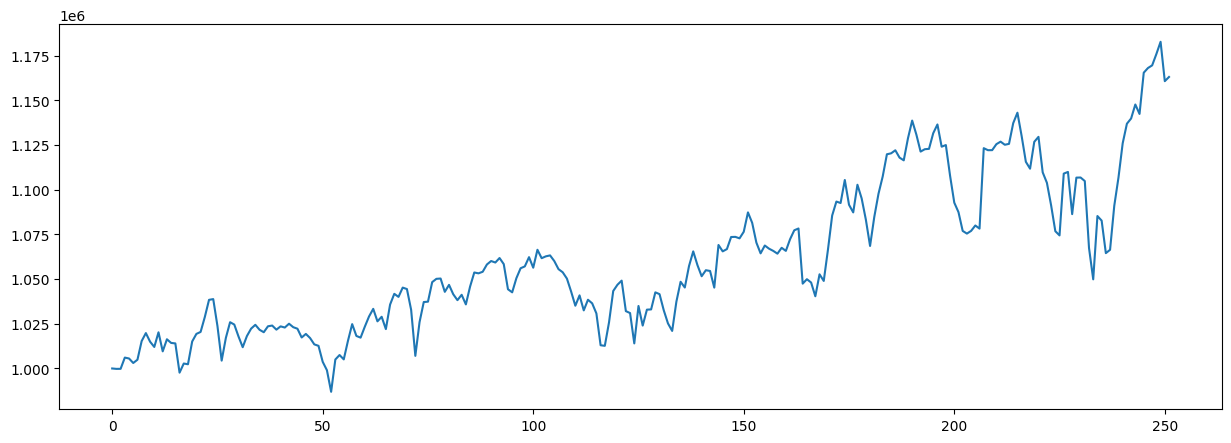

In [55]:
%matplotlib inline
df_account_value.account_value.plot()

In [56]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.163023
Cumulative returns     0.163023
Annual volatility      0.153650
Sharpe ratio           1.063463
Calmar ratio           1.999550
Stability              0.767015
Max drawdown          -0.081530
Omega ratio            1.206052
Sortino ratio          1.632181
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.078724
Daily value at risk   -0.018710
dtype: float64


In [57]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

[*********************100%***********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (251, 8)
Annual return          0.037486
Cumulative returns     0.037335
Annual volatility      0.134331
Sharpe ratio           0.342028
Calmar ratio           0.331049
Stability              0.066383
Max drawdown          -0.113235
Omega ratio            1.058031
Sortino ratio          0.480831
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.970301
Daily value at risk   -0.016742
dtype: float64


In [58]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')

df_dji:             date           dji
0    2021-04-06  1.000000e+06
1    2021-04-07  1.000479e+06
2    2021-04-08  1.002194e+06
3    2021-04-09  1.011079e+06
4    2021-04-12  1.009427e+06
..          ...           ...
247  2022-03-28  1.045637e+06
248  2022-03-29  1.055757e+06
249  2022-03-30  1.053801e+06
250  2022-03-31  1.037335e+06
251  2022-04-01           NaN

[252 rows x 2 columns]
df_dji:                       dji
date                    
2021-04-06  1.000000e+06
2021-04-07  1.000479e+06
2021-04-08  1.002194e+06
2021-04-09  1.011079e+06
2021-04-12  1.009427e+06
...                  ...
2022-03-28  1.045637e+06
2022-03-29  1.055757e+06
2022-03-30  1.053801e+06
2022-03-31  1.037335e+06
2022-04-01           NaN

[252 rows x 1 columns]


df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date:         datadate
0    2021-01-04
1    2021-01-05
2    2021-01-06
3    2021-01-07
4    2021-01-08
..          ...
350  2022-05-24
351  2022-05-25
352  2022-05-26
353  2022-05-27
354  2022-05-31

[355 rows x 1 columns]
df_result_ensemble:                  ensemble
date                    
2021-04-06  1.000000e+06
2021-04-07  9.997726e+05
2021-04-08  9.997998e+05
2021-04-09  1.006086e+06
2021-04-12  1.005580e+06
...                  ...
2022-03-28  1.169518e+06
2022-03-29  1.175855e+06
2022-03-30  1.182705e+06
2022-03-31  1.160672e+06
2022-04-01  1.163023e+06

[252 rows x 1 columns]
==============Compare to DJIA===========
result:                  ensemble           dji
date                                  
2021-04-06  1.000000e+06  1.000000e+06
2021-04-07  9.997726e+05  1.000479e+06
2021-04-08  9.997998e+05  1.002194e+06
2021-04-09  1.006086e+06  1.011079e+06
2021-04-12  1.005580e+06  1.009427e+06
...       

<Figure size 1500x500 with 0 Axes>

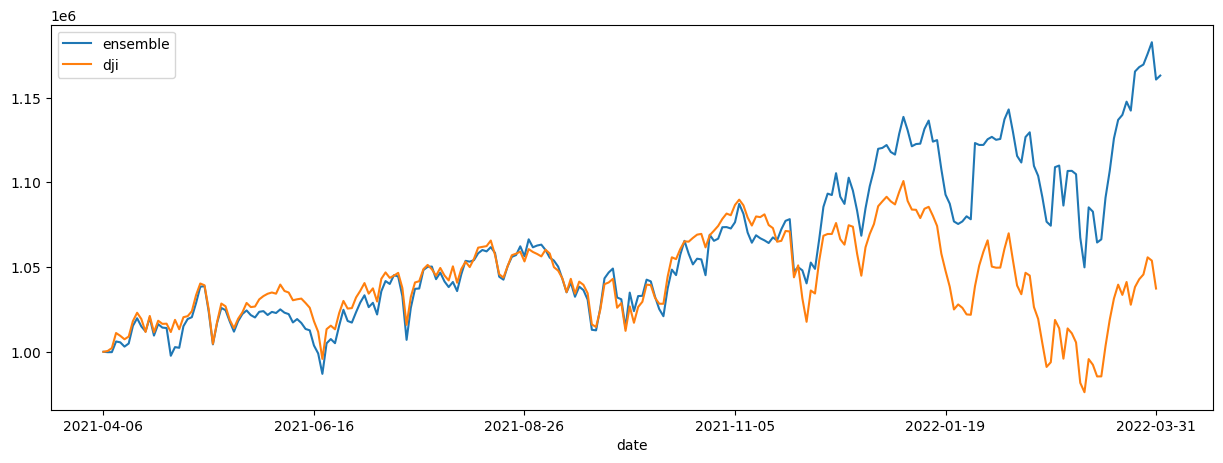

In [59]:
# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value,
#               baseline_ticker = '^DJI',
#               baseline_start = df_account_value.loc[0,'date'],
#               baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
print("==============Compare to DJIA===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
print("result: ", result)
result.to_csv("result.csv")
result.columns = ['ensemble', 'dji']

print(result)

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();